### how to organize the function file...

input arguments

- Current position of a GC
- structural parameters
- way to compute integration time

output a stream perhaps in h5...

In [134]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as MW14
from galpy.util import conversion

import numpy as np 
import matplotlib.pyplot as plt 
import h5py 
import trace_orbit as TO 
import json
import sys 
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import inputGC
import orbitCoords as OC
import astropy.coordinates as coord
import astropy.units as u

In [135]:
def cyl_to_cart(cylin):
    """
    PURPOSE:
        transform cylindrical coordinates along with velocities to cartesian
    cylin: np.array 6x1

    """
    R, vR, vT, z, vZ, phi=cylin[0],cylin[1],cylin[2],cylin[3],cylin[4],cylin[5]
    x,y=R*np.cos(phi),R*np.sin(phi)
    Rvec=np.array([x,y,0])
    Rmax=np.linalg.norm(Rvec)
    Runit=Rvec/Rmax 
    tanUnit=np.cross([0,0,1],Runit)
    VZ = np.array([0,0,vZ])
    VR = vR*Runit
    VT = vT*tanUnit
    vel=VZ+VR+VT
    return np.array([x,y,z,vel[0],vel[1],vel[2]])

In [136]:
def calcJacobii(laX,laY,laZ,satmass,model="PII"):
    """ CALCULATE THE THEORHETICAL JACOBI RADIUS
    For a satelite orbiting the galactic center
    assuming, fasly, in a spherically symmetric potential
    """
    G=1
    TOSOLAR=2.32*10**7
    ax,ay,az,_=inputMW.potMW(laX,laY,laZ,0,model)
    nabPhi=np.sqrt(ax**2 + ay**2 + az**2)
    r = np.sqrt(laX**2 + laY**2 + laZ**2)
    MASS = nabPhi*(r**2)*G*TOSOLAR
    jacobii=2.88 * ((satmass/MASS)**(1/3))*r 
    return jacobii

In [137]:
def escapeInitialConditions(R, vR, vT, z, vZ, escapFunc, phi,satmass,conv):
    """
    insert the coordinates of progenitor in natural units
    
    return the kinematics at the escape points in galpy format and in "natural" units
    
    assumes co-motion of the progenitor ie. forward moving orbit in time
    
    the interior and exterior escape particles have the same velocity as the GC

    escapFunc: a function used to calculate the escape radius. For now calcJacobii is supported
    
    """
    laX,laY=conv['ro']*R*np.cos(phi),conv['ro']*R*np.sin(phi)
    lat=np.arcsin(z/np.sqrt(R**2 + z**2))
    jacobii=escapFunc(laX,laY,conv['ro']*z,satmass)/conv['ro']
    rint = np.sqrt(R**2 + z**2) - jacobii
    rext = np.sqrt(R**2 + z**2) + jacobii
    Rint,zint=rint*np.cos(lat),rint*np.sin(lat)
    Rext,zext=rext*np.cos(lat),rext*np.sin(lat)
    interior = [Rint,vR,vT,zint,vZ,phi]
    exterior = [Rext,vR,vT,zext,vZ,phi]
    return interior,exterior

In [138]:
def cart_to_cylin(COM):
    """
    position and velocities to cylindrical in the galpy calling sequence
    return these with units
    """ 
    vel=np.array([COM.v_x.value, COM.v_y.value, COM.v_z.value])
    RR = np.array([COM.x.value, COM.y.value,0])
    R=np.sqrt (COM.x**2 + COM.y**2)
    magR = np.linalg.norm(RR)*u.kpc
    RUnit = RR/np.linalg.norm(RR) # cannot use "Quantity" 
    zUnit=[0,0,1]
    tanUnit=np.cross(zUnit,RUnit)
    # project velocity onto these axis and re-add units so that they are "Qauntity" objs
    vT=np.dot(vel,tanUnit)*u.km/u.s
    vR=np.dot(vel,RUnit)*u.km/u.s
    vZ=np.dot(vel,[0,0,1])*u.km/u.s    
    phi = np.arctan2(COM.y,COM.x)
    phi=phi.value*(180/np.pi)*u.degree
    return R,vR,vT,COM.z,vZ,phi

In [139]:
# load in current day information
GCname="Pal5"
COM=OC.getCOM(GCname)
params=inputGC.Plummer(GCname)
# convert to cylindrical
R,vR,vT,z,vZ,phi=cart_to_cylin(COM)

In [140]:
# initialize orbit backward
orbB=Orbit([R,-vR,-vT,z,-vZ,phi])
orbF=Orbit([R,vR,vT,z,vZ,phi])
# now put it in natural units
conv=conversion.get_physical(orbB)
tau = 5 # 100 Myrs so half a bilion years...
tauD = tau*(conv['vo']/conv['ro'])
N=600
ts=np.linspace(0,tauD,N)
orbB.integrate(ts,MW14)
orbF.integrate(ts,MW14)

In [141]:
borbit=orbB.getOrbit()
forbit=orbF.getOrbit()
borbit=np.flip(borbit,axis=0)
borbit[:,[1,2,4]]*=-1
fullorbit=np.concatenate([borbit[:-1,:],forbit])

In [142]:
def particleSpray(ts,fullorbit,satmass,conv,escapFunc):
    """ 
    All in natural units. 
    find the final positions of the particles that escape from the time stamps given by ts
    
    ts must be the N//2 where N is the length of full orbit

    escapFunc = a function that takes in the kinematics and and such and returns the kinematics of the particles at the escape points
    """
    N = ts.shape[0]
    leadingF=np.zeros((N-1,6))
    trailingF=np.zeros((N-1,6))
    tf=ts[-1]
    for i in range(N-1):
        R, vR, vT, z, vZ, phi = fullorbit[i,:]
        interior,exterior=escapeInitialConditions(R, vR, vT, z, vZ, escapFunc, phi,satmass,conv)
        intOrb=Orbit(interior)
        extOrb=Orbit(exterior)
        inttime=np.linspace(0,tf-ts[i],N-i)
        intOrb.integrate(inttime,MW14)
        extOrb.integrate(inttime,MW14)
        leadingF[i,:]=intOrb.getOrbit()[-1,:]
        trailingF[i,:]=extOrb.getOrbit()[-1,:]
    return leadingF, trailingF

In [143]:
leadingF, trailingF=particleSpray(ts,fullorbit,params[0],conv,calcJacobii)

### Now save the output data!

In [144]:
C={}
C["dataset"]="EDR3"
C["MWpoten"]="Bovy2014" # MWPotential2014
C["GCpoten"]="PSpray"
C["Nstep"] = N 
C['deltat'] = None
C['Np'] = N-1
C["T"] = ts[-1]
C["comment"] = "the integration time is in 100 Myrs"

In [145]:
leadCart=np.zeros(leadingF.shape)
trailCart=np.zeros(trailingF.shape)
for i in range(leadingF.shape[0]):
    leadCart[i,:] = cyl_to_cart(leadingF[i,:])
    trailCart[i,:] = cyl_to_cart(trailingF[i,:])

x=np.concatenate((leadCart[:,0],trailCart[:,0]))*conv['ro']*u.kpc
y=np.concatenate((leadCart[:,1],trailCart[:,1]))*conv['ro']*u.kpc
z=np.concatenate((leadCart[:,2],trailCart[:,2]))*conv['ro']*u.kpc
vx=np.concatenate((leadCart[:,3],trailCart[:,3]))*conv['vo']*u.km/u.s
vy=np.concatenate((leadCart[:,4],trailCart[:,4]))*conv['vo']*u.km/u.s
vz=np.concatenate((leadCart[:,5],trailCart[:,5]))*conv['vo']*u.km/u.s

In [146]:
tsRealUnits = np.flip(ts[:-1]) * (conv['ro']/conv['vo'])
tEscOut=np.concatenate((tsRealUnits,tsRealUnits))

In [151]:
galacto=coord.SkyCoord(x=x,y=y,z=z,v_x=vx,v_y=vy,v_z=vz,frame=inputMW.ref_frame())

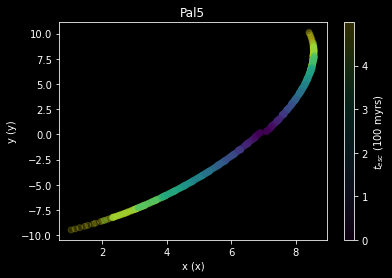

In [147]:
plt.style.use('dark_background')
width=40
dexes=np.arange(fullorbit.shape[0]//2 - width, fullorbit.shape[0]//2 + width,)
# plt.plot(fullorbit[dexes,0],fullorbit[dexes,3])
# plt.scatter(leadingF[:,0],leadingF[:,3],c=tsRealUnits,alpha=0.2)
# im=plt.scatter(trailingF[:,0],trailingF[:,3],c=tsRealUnits,alpha=0.2)
im=plt.scatter(x,y,c=tEscOut,alpha=0.2)
# plt.xlim(leadingF[:,0].min(),trailingF[:,0].max())
# plt.ylim(leadingF[:,3].min(),trailingF[:,3].max())

plt.xlabel("x (x)")
plt.ylabel("y (y)")
plt.title(GCname)
cbar=plt.colorbar(im)
cbar.set_label(r"$t_{esc}$ (100 myrs)")

In [125]:
# get the H5 stuff going!!!
galacto=coord.SkyCoord(x=x,y=y,z=z,v_x=vx,v_y=vy,v_z=vz,frame=inputMW.ref_frame())
sky=galacto.transform_to('icrs')
galactic=galacto.transform_to(coord.Galactic)

In [127]:
hf = h5py.File('test.h5', 'w')
sky = galacto.transform_to(coord.ICRS)
ra = sky.ra.value
dec = sky.dec.value
D = sky.distance.value
pm_ra_cosdec = sky.pm_ra_cosdec.value
pm_dec = sky.pm_dec.value
RV = sky.radial_velocity.value

galactic = sky.transform_to('galactic')
ll = galactic.l.value
l = ll
l[ll > 180] = l[ll > 180] - 360.
b = galactic.b.value
pm_l_cosb = galactic.pm_l_cosb.value
pm_b = galactic.pm_b.value

EQ = hf.create_group('equatorial')
EQ.create_dataset('RA', data=ra)
EQ.create_dataset('DEC', data=dec)
EQ.create_dataset('D', data=D)
EQ.create_dataset('PMRA_COSDEC', data=pm_ra_cosdec)
EQ.create_dataset('PMDEC', data=pm_dec)
EQ.create_dataset('RV', data=RV)
GAL = hf.create_group('galactic')
GAL.create_dataset('LONG', data=l)
GAL.create_dataset('LAT', data=b)
GAL.create_dataset('PML_COSB', data=pm_l_cosb)
GAL.create_dataset('PMB', data=pm_b)
GALCEN = hf.create_group('galactocentric')
GALCEN.create_dataset('X', data=x)
GALCEN.create_dataset('Y', data=y)
GALCEN.create_dataset('Z', data=z)
GALCEN.create_dataset('VX', data=vx)
GALCEN.create_dataset('VY', data=vy)
GALCEN.create_dataset('VZ', data=vz)
ENERGY = hf.create_group('energy')
ENERGY.create_dataset('Tescape', data=tesc)
hf.close()

OSError: Unable to create file (unable to truncate a file which is already open)

: 

I'm unsure about the units of the potential... Here's me trying to make a minnimum working example...

In [ ]:
from galpy.potential import evaluatePotentials
from galpy.potential import MWPotential2014 as MW14
conv=conversion.get_physical(orbB)
import astropy.units as u
x,y,z = 6.9897298*u.kpc,0.22368721*u.kpc,15.72140384*u.kpc
vx,vy,vz=47.50720478*u.km/u.s,143.2984329*u.km/u.s,11.80115388*u.km/u.s
R = np.sqrt(x**2 + y**2)
_,_,_,phi=inputMW.potMW(x[0].value,y[0].value,z[0].value,0,"PII")
print(phi)
print(evaluatePotentials(MW14,R,z))

## make the plots really quick!

In [29]:
import h5py 
import numpy as np 
import matplotlib.pyplot as plt 
import orbitCoords as OC
import sys
sys.path.append("/home/sferrone/GC-tidal-loss/simulations/analytic-GC-tidal-loss/code")
import inputMW
import inputGC
import astropy.units as u 


In [128]:
GCname="Pal5"
path="/home/sferrone/outputDATA/EDR3/Bovy2014/PSpray/T-5/backward/streams/Np-599/"
stream=h5py.File(path+GCname+".h5")

In [129]:
# calculate the orbit
COM=OC.getCOM(GCname)
params=inputGC.Plummer(GCname)
# convert to cylindrical
R,vR,vT,z,vZ,phi=cart_to_cylin(COM)
orbB=Orbit([R,-vR,-vT,z,-vZ,phi])
orbF=Orbit([R,vR,vT,z,vZ,phi])
# now put it in natural units
conv=conversion.get_physical(orbB)
tau = .001 # 100 Myrs so half a bilion years...
tauD = tau*(conv['vo']/conv['ro'])
N=600
orbtime = np.concatenate((-np.flip(ts),ts))/conv['vo']/conv['ro']
ts=np.linspace(0,tauD,N)
orbB.integrate(ts,MW14)
orbF.integrate(ts,MW14)

In [130]:
borbit=orbB.getOrbit()
forbit=orbF.getOrbit()
borbit=np.flip(borbit,axis=0)
borbit[:,[1,2,4]]*=-1
fullorbit=np.concatenate([borbit[:-1,:],forbit])
orbCart=np.zeros(fullorbit.shape)
for i in range(fullorbit.shape[0]):
    orbCart[i,:] = cyl_to_cart(fullorbit[i,:])
x=orbCart[:,0]*conv['ro']*u.kpc
y=orbCart[:,1]*conv['ro']*u.kpc
z=orbCart[:,2]*conv['ro']*u.kpc
vx=orbCart[:,3]*conv['vo']*u.km/u.s
vy=orbCart[:,4]*conv['vo']*u.km/u.s
vz=orbCart[:,5]*conv['vo']*u.km/u.s
galacto=coord.SkyCoord(x=x,y=y,z=z,v_x=vx,v_y=vy,v_z=vz,frame=inputMW.ref_frame())
galactic=galacto.transform_to(coord.Galactic)

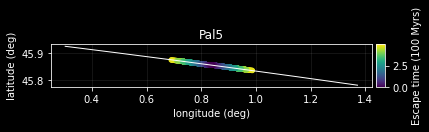

In [131]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
fig,ax=plt.subplots(1,1)
ax.plot(galactic.l.wrap_at(180*u.degree),galactic.b,color='w',linewidth=1)
im=ax.scatter(stream['galactic']['LONG'],stream['galactic']['LAT'],c=stream['energy']['Tescape'],s=20)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(im, cax=cax)
cbar.set_label("Escape time (100 Myrs)")
ax.set_aspect("equal")
ax.set_ylabel("latitude (deg)")
ax.set_xlabel("longitude (deg)")
ax.set_title(GCname)
ax.grid("on",alpha=0.1)

## now put this in the other coordinate system to compare..

In [132]:
# initialize output
Xp,Yp,Zp=stream['galactocentric']['X'][:],stream['galactocentric']['Y'][:],stream['galactocentric']['Z'][:]
VXp,VYp,VZp=stream['galactocentric']['VX'][:],stream['galactocentric']['VY'][:],stream['galactocentric']['VZ'][:]
xprime,indexes,tt=np.zeros(Xp.shape),np.zeros(Xp.shape),np.zeros(Xp.shape)
orbCoords,velCoords=np.zeros((Xp.shape[0],3)),np.zeros((Xp.shape[0],3))
xprimeORB=np.zeros(x.shape)
xcom,ycom,zcom=COM.x.value,COM.y.value,COM.z.value
xprimeORB=OC.define_orbital_coordinate(x.value, y.value, z.value, xcom, ycom, zcom, xprimeORB)
tt, xprime, orbCoords, indexes,velCoords = OC.getorbcoords(
Xp, Yp, Zp, VXp, VYp, VZp, orbtime, x.value, y.value, z.value, vx.value, vy.value, vz.value, xprimeORB, tt, xprime, orbCoords, velCoords, indexes)
cond0=stream['energy']['Tescape'][:]>0


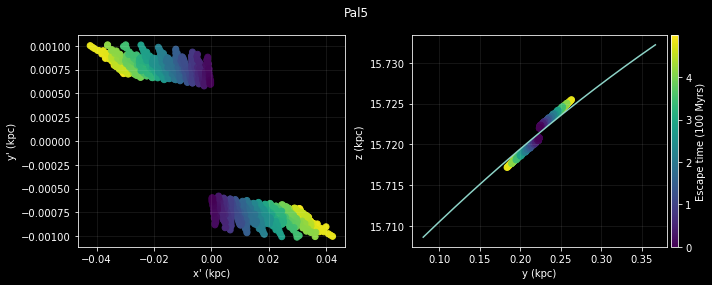

In [133]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(xprime,orbCoords[:,0], c=stream['energy']['Tescape'],)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(im, cax=cax)
cbar.set_label("Escape time (100 Myrs)")
ax[0].set_ylabel("y' (kpc)")
ax[0].set_xlabel("x' (kpc)")
ax[0].grid("on",alpha=0.1)
fig.suptitle(GCname)
ax[1].plot(galacto.y,galacto.z)
ax[1].scatter(stream['galactocentric']['Y'][:],stream['galactocentric']['Z'][:],c=stream['energy']['Tescape'])
ax[1].set_ylabel("z (kpc)")
ax[1].set_xlabel("y (kpc)")
ax[1].grid("on",alpha=0.1)
fig.tight_layout()